In [1]:
from sqlalchemy import create_engine
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
from pathlib import Path

env_path = Path('../env')
load_dotenv(dotenv_path=env_path)

DB_TORONTO_TRAFFIC_COLLISIONS_ALL = os.getenv('DB_TORONTO_TRAFFIC_COLLISIONS_ALL')

engine = create_engine(DB_TORONTO_TRAFFIC_COLLISIONS_ALL)

Exploratory data analysis

1. Summary Statistics

array([[<AxesSubplot:title={'center':'_id'}>,
        <AxesSubplot:title={'center':'OCC_DATE'}>,
        <AxesSubplot:title={'center':'OCC_YEAR'}>,
        <AxesSubplot:title={'center':'OCC_HOUR'}>],
       [<AxesSubplot:title={'center':'FATALITIES'}>,
        <AxesSubplot:title={'center':'INJURY_COLLISIONS'}>,
        <AxesSubplot:title={'center':'FTR_COLLISIONS'}>,
        <AxesSubplot:title={'center':'PD_COLLISIONS'}>],
       [<AxesSubplot:title={'center':'LONG_WGS84'}>,
        <AxesSubplot:title={'center':'LAT_WGS84'}>,
        <AxesSubplot:title={'center':'AUTOMOBILE'}>,
        <AxesSubplot:title={'center':'MOTORCYCLE'}>],
       [<AxesSubplot:title={'center':'PASSENGER'}>,
        <AxesSubplot:title={'center':'BICYCLE'}>,
        <AxesSubplot:title={'center':'PEDESTRIAN'}>,
        <AxesSubplot:title={'center':'has_valid_location'}>],
       [<AxesSubplot:title={'center':'OCC_DOM'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

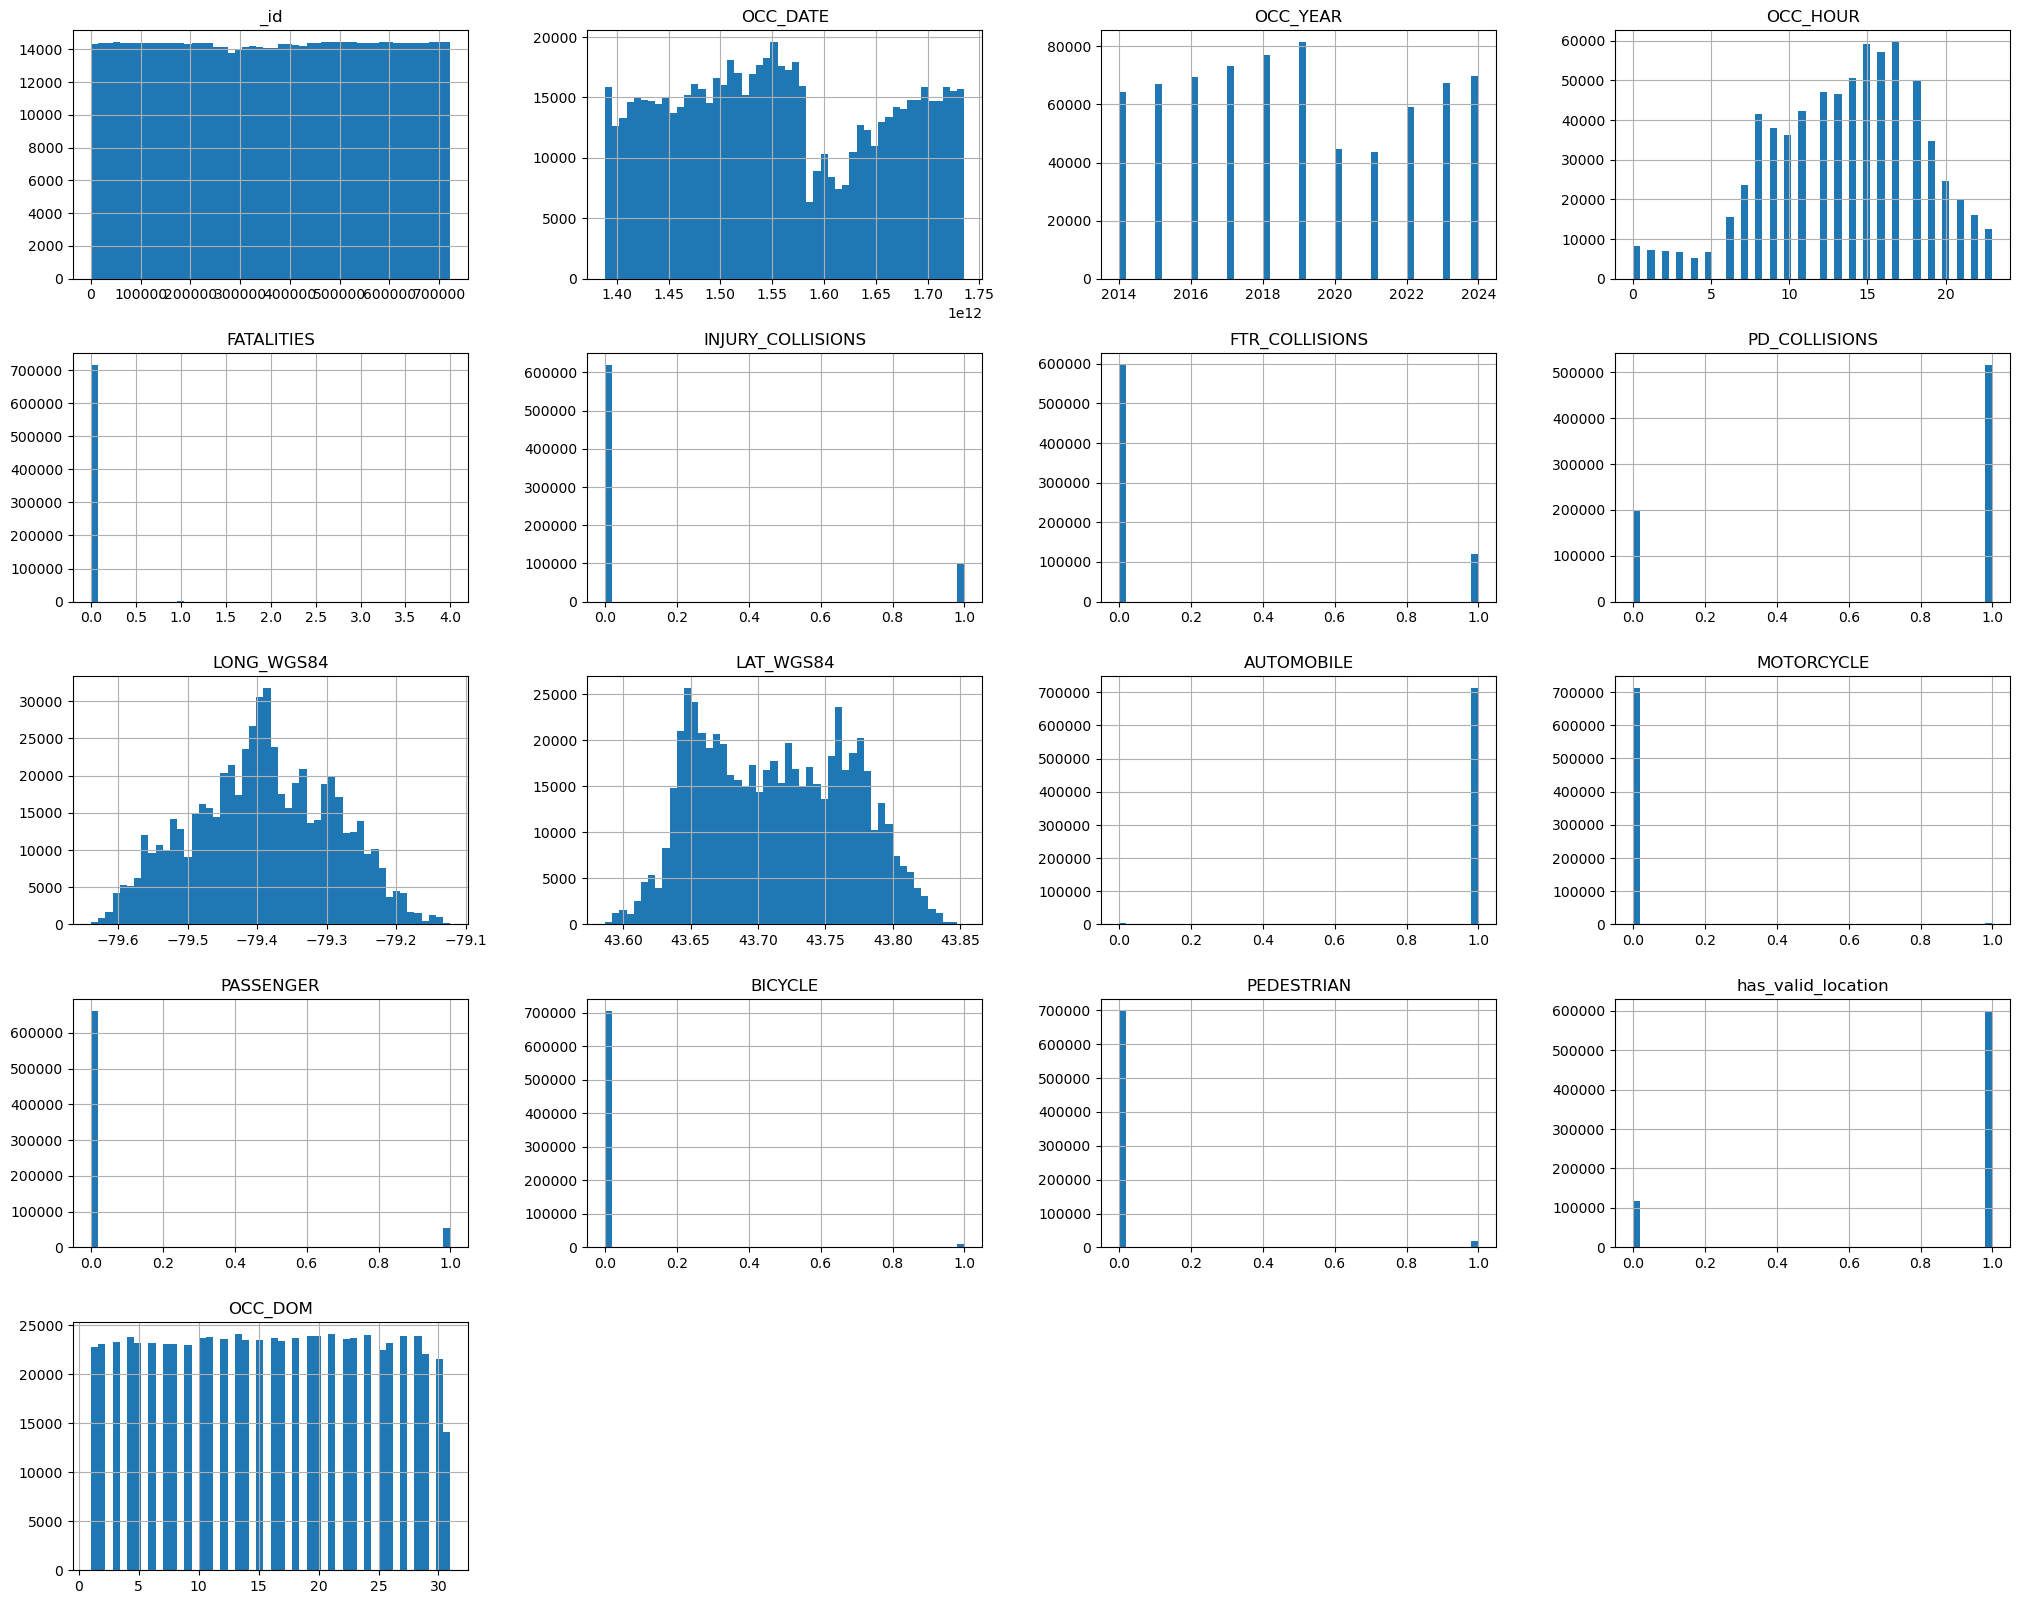

In [2]:
# get the summary histogram plot
query_1 = "SELECT * FROM collisions"
gdf_all = gpd.read_postgis(query_1, engine, geom_col="geometry")
gdf_all.hist(bins=50, figsize=(25, 20))

In [14]:
total_no_entries = len(gdf_all)
print("total no of enteries:", total_no_entries)

total no of enteries: 716491


2. plot the hist of no. of car collision by day of the week

<AxesSubplot:title={'center':'No.of collisions by the day of week'}, xlabel='OCC_DOW'>

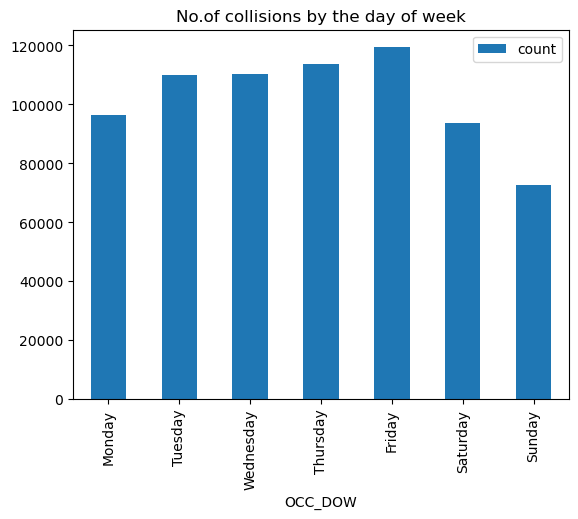

In [3]:
query_2 = """
SELECT "OCC_DOW", COUNT(*)
FROM collisions
GROUP BY "OCC_DOW"
ORDER BY (CASE
    WHEN "OCC_DOW"='Monday' THEN 1
    WHEN "OCC_DOW"='Tuesday' THEN 2
    WHEN "OCC_DOW"='Wednesday' THEN 3
    WHEN "OCC_DOW"='Thursday' THEN 4
    WHEN "OCC_DOW"='Friday' THEN 5
    WHEN "OCC_DOW"='Saturday' THEN 6
    ELSE 7
END)
"""
df_collisions_by_week = pd.read_sql_query(query_2, engine)
df_collisions_by_week.plot.bar(x='OCC_DOW', y='count', title="No.of collisions by the day of week")


3. Investiagte the peak hour of collision of the day in each day of the week


In [4]:
query_3 = """
SELECT "OCC_DOW", "OCC_HOUR", COUNT(*)
FROM collisions
GROUP BY "OCC_DOW", "OCC_HOUR"
ORDER BY (CASE
    WHEN "OCC_DOW"='Monday' THEN 1
    WHEN "OCC_DOW"='Tuesday' THEN 2
    WHEN "OCC_DOW"='Wednesday' THEN 3
    WHEN "OCC_DOW"='Thursday' THEN 4
    WHEN "OCC_DOW"='Friday' THEN 5
    WHEN "OCC_DOW"='Saturday' THEN 6
    ELSE 7
    END), "OCC_HOUR"
"""
df_day_hour = pd.read_sql_query(query_3, engine)
df_day_hour


,OCC_DOW,OCC_HOUR,count
0,Monday,0,1007
1,Monday,1,850
2,Monday,2,777
3,Monday,3,831
4,Monday,4,703
...,...,...,...
163,Sunday,19,3628
164,Sunday,20,3007
165,Sunday,21,2419
166,Sunday,22,1938


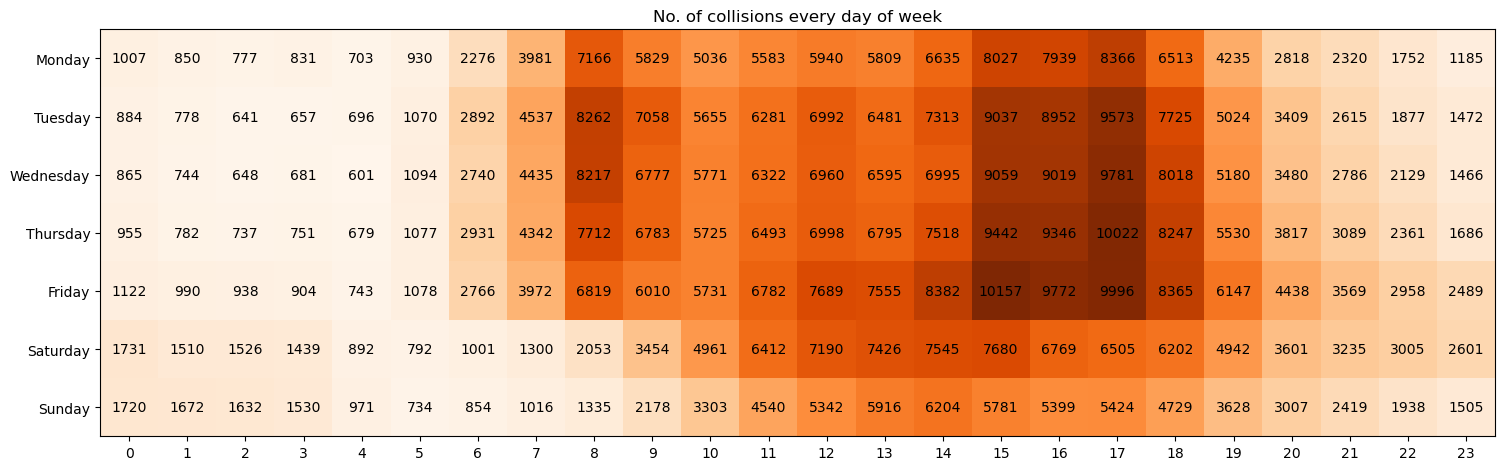

In [5]:
# turn count into 2d matrix
count = df_day_hour['count']

# data
day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data = []
for i in range(7):
    row = []
    for j in range(24):
        row.append(count.iloc[i *24 + j])
    data.append(row)

fig, ax = plt.subplots(figsize=(18,8))
im = ax.imshow(data, cmap="Oranges")

# set title
ax.set_title("No. of collisions every day of week")

# label the axis
ax.set_xticks(range(24))
ax.set_yticks(range(len(day_of_week)), labels=day_of_week)

# text annotations
for i in range(7):
    for j in range(24):
        text = ax.text(j, i, data[i][j],
                       ha="center", va="center")

# set size


plt.show()


It is observed that the no. of collisions on friday night, particularly friday towards midnight is higher than that of other weekdays. 
(2489 on friday 2300 vs. 1686 on thursday 2300 - around 50% increase!)

We would like to conduct further analysis on that later.

Also, do note there are cases of collisions that does not an specified address. It is suspected that the reporting process is abrupt.
We would like to see if the NSA ratio is the same for collisions happening in each hour of each day of the week.

In [15]:
query_4_nsa_count = """
SELECT COUNT(*) FROM collisions
WHERE (has_valid_location = 0)
"""
df_nsa_count = pd.read_sql_query(query_4_nsa_count, engine)
print("nsa count: ", df_nsa_count.iloc[0, 0])
print("nsa ratio: ", df_nsa_count.iloc[0, 0]/total_no_entries)

nsa count:  116664
nsa ratio:  0.1628268882651701


In [6]:
query_4_nsa = """
SELECT "OCC_DOW", "OCC_HOUR", COUNT(*)
FROM collisions
WHERE (has_valid_location = 0)
GROUP BY "OCC_DOW", "OCC_HOUR"
ORDER BY (CASE
    WHEN "OCC_DOW"='Monday' THEN 1
    WHEN "OCC_DOW"='Tuesday' THEN 2
    WHEN "OCC_DOW"='Wednesday' THEN 3
    WHEN "OCC_DOW"='Thursday' THEN 4
    WHEN "OCC_DOW"='Friday' THEN 5
    WHEN "OCC_DOW"='Saturday' THEN 6
    ELSE 7
    END), "OCC_HOUR"
"""
df_day_hour_nsa = pd.read_sql_query(query_4_nsa, engine)
df_day_hour_nsa



,OCC_DOW,OCC_HOUR,count
0,Monday,0,144
1,Monday,1,140
2,Monday,2,139
3,Monday,3,165
4,Monday,4,137
...,...,...,...
163,Sunday,19,575
164,Sunday,20,436
165,Sunday,21,324
166,Sunday,22,265


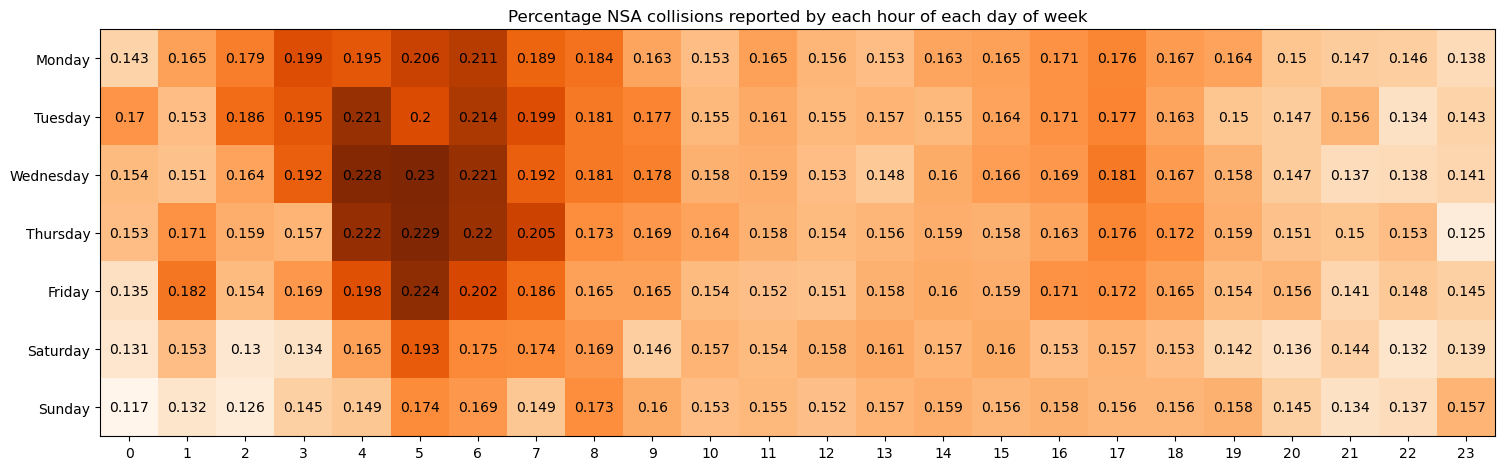

In [7]:
# turn count into 2d matrix
count = df_day_hour['count']
count_nsa = df_day_hour_nsa['count']

# data
day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data = []
for i in range(7):
    row = []
    for j in range(24):
        row.append(round(count_nsa.iloc[i * 24 + j]/count.iloc[i * 24 + j], 3))
    data.append(row)

fig, ax = plt.subplots(figsize=(18,8))
im = ax.imshow(data, cmap="Oranges")

# set title
ax.set_title("Percentage NSA collisions reported by each hour of each day of week")

# label the axis
ax.set_xticks(range(24))
ax.set_yticks(range(len(day_of_week)), labels=day_of_week)

# text annotations
for i in range(7):
    for j in range(24):
        text = ax.text(j, i, data[i][j],
                       ha="center", va="center")

# set size


plt.show()

Referring to the heatmap above, there are a higher portion of cases that are reported without Specified Address (NSA) during very early morning in weekdays and during the evenings.

It is observed that saturday and sunday right after midnight have a lower proportion of NSA cases.

We would also like to investiage the percentage of fail to remain cases per hour of every day of the week.

In [17]:
query_5_ftr_count = """
SELECT COUNT(*) FROM collisions
WHERE ("FTR_COLLISIONS" = 1)
"""
df_ftr_count = pd.read_sql_query(query_5_ftr_count, engine)
print("ftr count: ", df_ftr_count.iloc[0, 0])
print("ftr ratio: ", df_ftr_count.iloc[0, 0]/total_no_entries)

ftr count:  119550
ftr ratio:  0.1668548523289197


In [8]:
query_5_ftr = """
SELECT "OCC_DOW", "OCC_HOUR", COUNT(*)
FROM collisions
WHERE ("FTR_COLLISIONS" = 1)
GROUP BY "OCC_DOW", "OCC_HOUR"
ORDER BY (CASE
    WHEN "OCC_DOW"='Monday' THEN 1
    WHEN "OCC_DOW"='Tuesday' THEN 2
    WHEN "OCC_DOW"='Wednesday' THEN 3
    WHEN "OCC_DOW"='Thursday' THEN 4
    WHEN "OCC_DOW"='Friday' THEN 5
    WHEN "OCC_DOW"='Saturday' THEN 6
    ELSE 7
    END), "OCC_HOUR"
"""
df_day_hour_ftr = pd.read_sql_query(query_5_ftr, engine)
df_day_hour_ftr


,OCC_DOW,OCC_HOUR,count
0,Monday,0,363
1,Monday,1,224
2,Monday,2,181
3,Monday,3,204
4,Monday,4,147
...,...,...,...
163,Sunday,19,721
164,Sunday,20,636
165,Sunday,21,530
166,Sunday,22,442


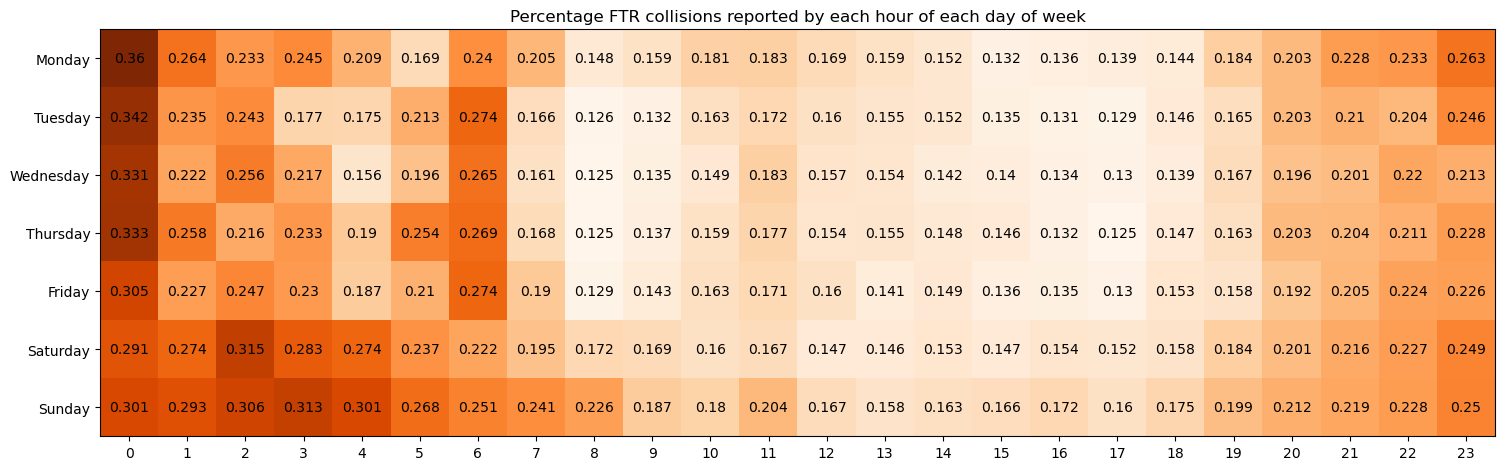

In [9]:
# turn count into 2d matrix
count = df_day_hour['count']
count_ftr = df_day_hour_ftr['count']

# data
day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data = []
for i in range(7):
    row = []
    for j in range(24):
        row.append(round(count_ftr.iloc[i * 24 + j]/count.iloc[i * 24 + j], 3))
    data.append(row)

fig, ax = plt.subplots(figsize=(18,8))
im = ax.imshow(data, cmap="Oranges")

# set title
ax.set_title("Percentage FTR collisions reported by each hour of each day of week")

# label the axis
ax.set_xticks(range(24))
ax.set_yticks(range(len(day_of_week)), labels=day_of_week)

# text annotations
for i in range(7):
    for j in range(24):
        text = ax.text(j, i, data[i][j],
                       ha="center", va="center")

# set size

plt.show()

There is a larger percentage of fail-to-remain collisions during midnight.

We would like investiage the percentage of cases that has assiocated with injury by each hour of the day of week.

In [10]:
query_6_injury = """
SELECT "OCC_DOW", "OCC_HOUR", COUNT(*)
FROM collisions
WHERE ("INJURY_COLLISIONS" = 1)
GROUP BY "OCC_DOW", "OCC_HOUR"
ORDER BY (CASE
    WHEN "OCC_DOW"='Monday' THEN 1
    WHEN "OCC_DOW"='Tuesday' THEN 2
    WHEN "OCC_DOW"='Wednesday' THEN 3
    WHEN "OCC_DOW"='Thursday' THEN 4
    WHEN "OCC_DOW"='Friday' THEN 5
    WHEN "OCC_DOW"='Saturday' THEN 6
    ELSE 7
    END), "OCC_HOUR"
"""
df_day_hour_injury = pd.read_sql_query(query_6_injury, engine)
df_day_hour_injury

,OCC_DOW,OCC_HOUR,count
0,Monday,0,130
1,Monday,1,105
2,Monday,2,80
3,Monday,3,69
4,Monday,4,64
...,...,...,...
163,Sunday,19,571
164,Sunday,20,478
165,Sunday,21,445
166,Sunday,22,364


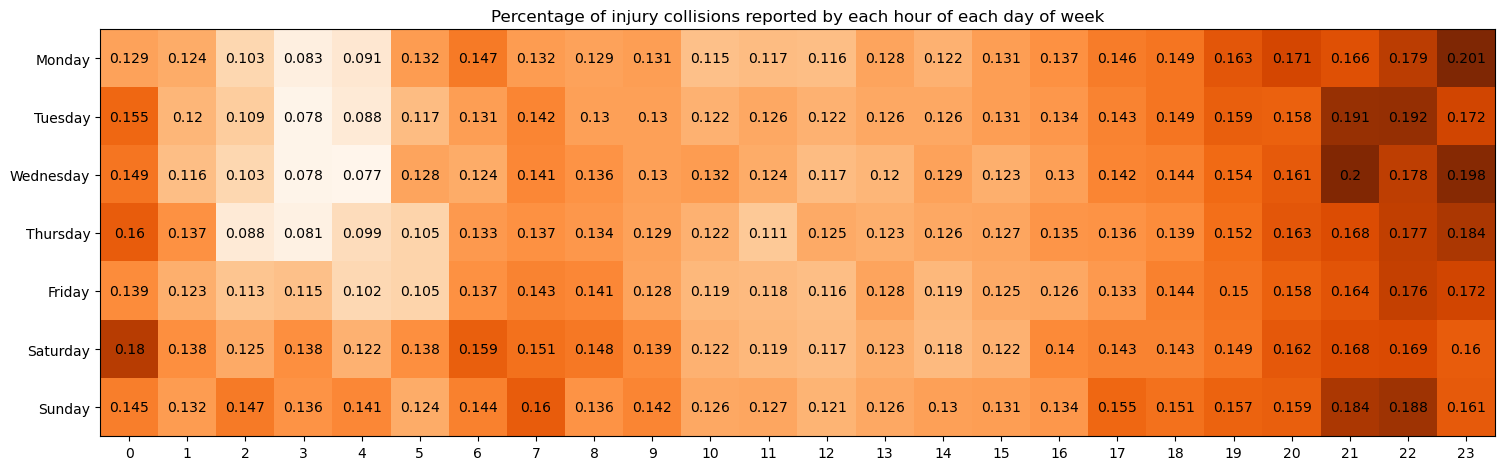

In [11]:
# turn count into 2d matrix
count = df_day_hour['count']
count_injury = df_day_hour_injury['count']

# data
day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data = []
for i in range(7):
    row = []
    for j in range(24):
        row.append(round(count_injury.iloc[i * 24 + j]/count.iloc[i * 24 + j], 3))
    data.append(row)

fig, ax = plt.subplots(figsize=(18,8))
im = ax.imshow(data, cmap="Oranges")

# set title
ax.set_title("Percentage of injury collisions reported by each hour of each day of week")

# label the axis
ax.set_xticks(range(24))
ax.set_yticks(range(len(day_of_week)), labels=day_of_week)

# text annotations
for i in range(7):
    for j in range(24):
        text = ax.text(j, i, data[i][j],
                       ha="center", va="center")

# set size

plt.show()

We would also like to investigate the no of collisions per day from 2014 to 2024.

        OCC_DATE  count OCC_DATE_READABLE
0  1587272400000     27        2020-04-19
1  1586667600000     28        2020-04-12
2  1587877200000     32        2020-04-26
3  1584853200000     33        2020-03-22
4  1587186000000     33        2020-04-18
5  1585458000000     35        2020-03-29
6  1611464400000     36        2021-01-24
7  1586235600000     37        2020-04-07
8  1587790800000     38        2020-04-25
9  1586494800000     39        2020-04-10
           OCC_DATE  count OCC_DATE_READABLE
4008  1548824400000    417        2019-01-30
4009  1510290000000    420        2017-11-10
4010  1548997200000    435        2019-02-01
4011  1548910800000    438        2019-01-31
4012  1424494800000    491        2015-02-21
4013  1548651600000    495        2019-01-28
4014  1707973200000    500        2024-02-15
4015  1573448400000    531        2019-11-11
4016  1711083600000    667        2024-03-22
4017  1551243600000    677        2019-02-27


<AxesSubplot:>

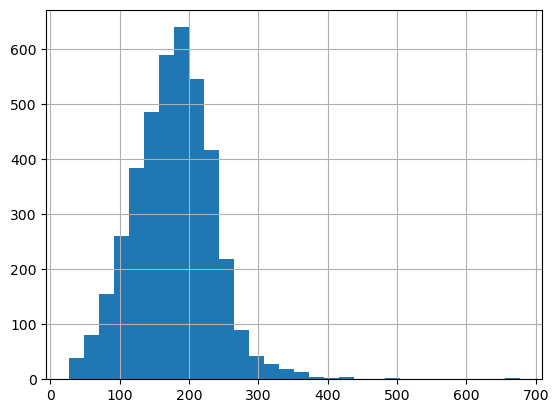

In [38]:
query_7_collisions_per_day = """
SELECT "OCC_DATE", COUNT(*) 
FROM collisions
GROUP BY "OCC_DATE"
ORDER BY count
"""

df_collisions_per_day = pd.read_sql_query(query_7_collisions_per_day, engine)

from datetime import datetime
df_collisions_per_day["OCC_DATE_READABLE"] = pd.to_datetime(df_collisions_per_day["OCC_DATE"], unit='ms').dt.date

print(df_collisions_per_day.head(n=10))
print(df_collisions_per_day.tail(n=10))
df_collisions_per_day["count"].hist(bins=30)